In [ ]:
from bayes_tec.datapack import DataPack
from bayes_tec.models.heteroscedastic_phaseonly_svgp import HeteroscedasticPhaseOnlySVGP
from bayes_tec.likelihoods import ItohGaussianEncodedHetero
from bayes_tec.kernels import SpectralMixture
# from bayes_tec.bayes_opt.bayes_hp_opt import BayesHPOpt
from bayes_tec.utils.data_utils import calculate_weights, make_coord_array
from bayes_tec.utils.gpflow_utils import LogisticVec, train_with_nat
from bayes_tec.kernels import SpectralMixture
import gpflow as gp
import numpy as np
import pylab as plt
from bayes_tec.utils.data_utils import calculate_empirical_spectral_kern, solve_spectral_mixture

In [ ]:
with DataPack('../../scripts/data/killms_datapack_4.hdf5', readonly=False) as datapack:
    datapack.select(ant=slice(None,None,1),freq=slice(0,48,1),pol=slice(0,1,1),dir=None,time=None)
    phase, axes = datapack.phase
    tec, _ = datapack.tec
#     weights_tec,_ = datapack.weights_tec
    Npol, Nd, Na, Nt = tec.shape
    _, time = datapack.get_times(axes['time'])
    _, freqs = datapack.get_freqs(axes['freq'])
    _, directions = datapack.get_sources(axes['dir'])

## Investigate coupling between antennas

2018-11-10 19:36:51,529 update_title_pos
2018-11-10 19:36:51,546 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:36:51,582 update_title_pos
2018-11-10 19:36:51,632 update_title_pos
2018-11-10 19:36:51,669 update_title_pos
2018-11-10 19:36:51,712 update_title_pos
2018-11-10 19:36:51,768 update_title_pos
2018-11-10 19:36:51,811 update_title_pos
2018-11-10 19:36:51,847 update_title_pos
2018-11-10 19:36:51,882 update_title_pos
2018-11-10 19:36:51,922 update_title_pos
2018-11-10 19:36:52,009 update_title_pos
2018-11-10 19:36:52,084 update_title_pos
2018-11-10 19:36:52,140 update_title_pos
2018-11-10 19:36:52,194 update_title_pos
2018-11-10 19:36:52,237 update_title_pos
2018-11-10 19:36:52,286 update_title_pos
2018-11-10 1

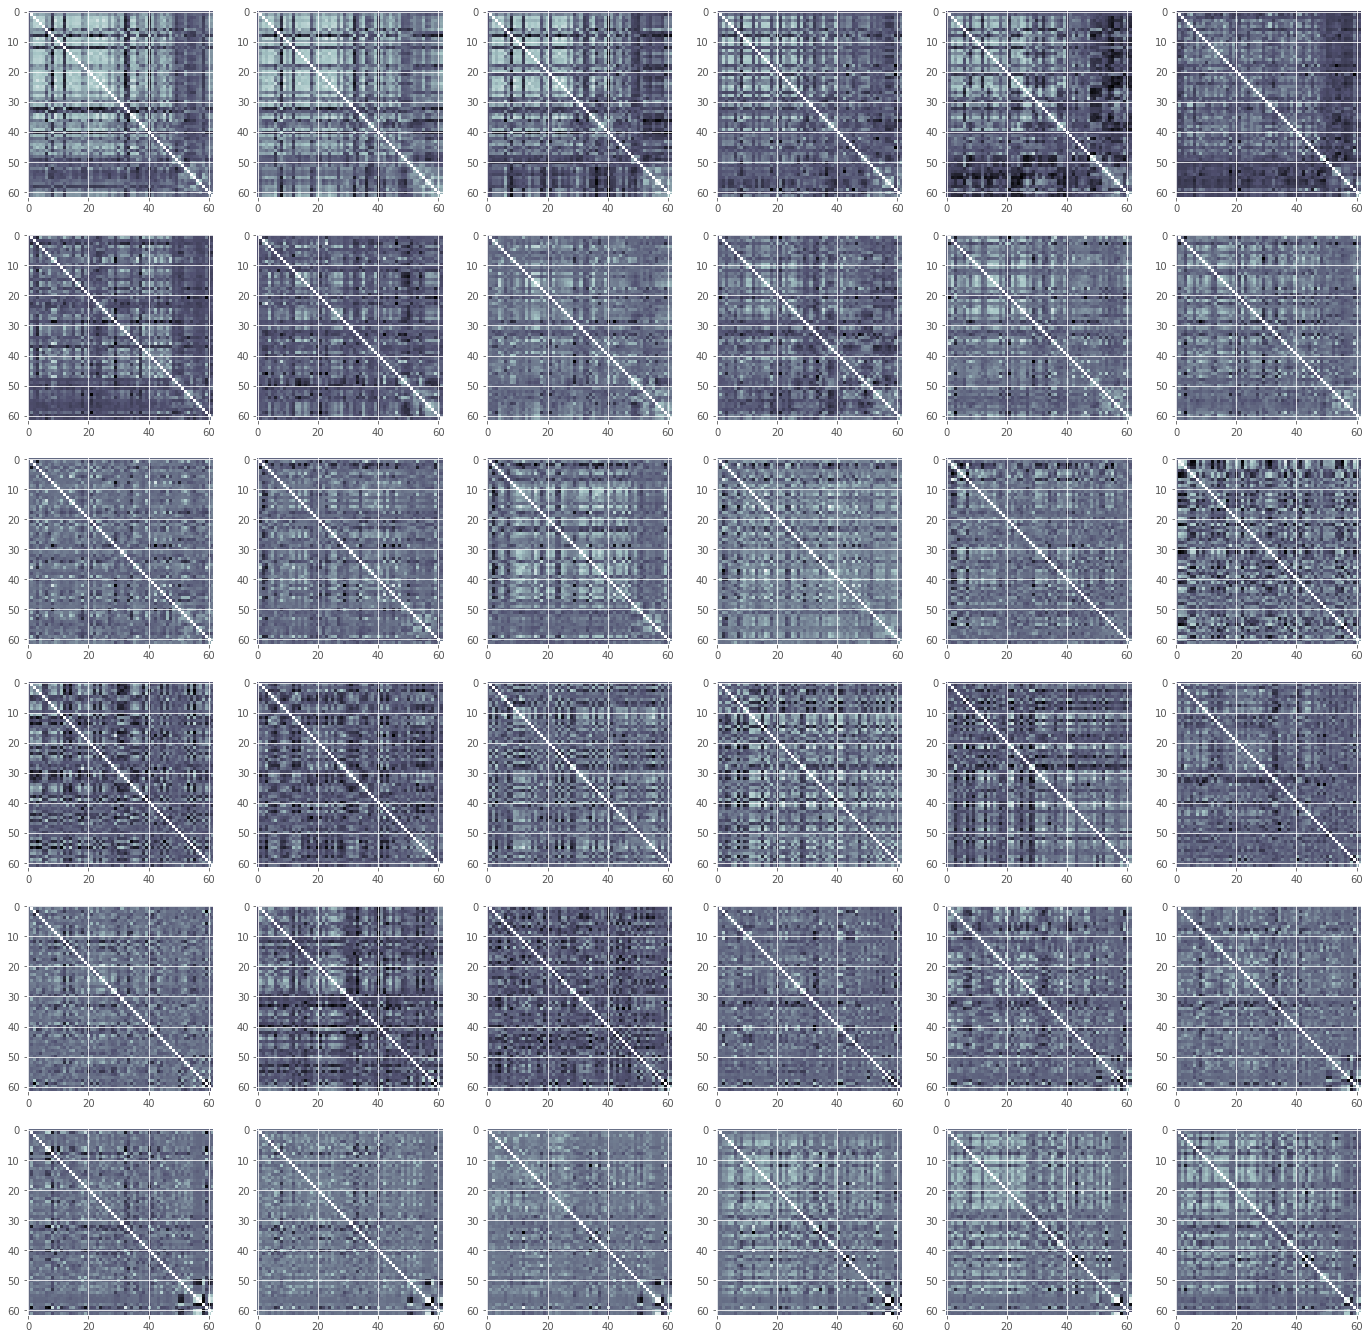

In [8]:

block_size = 100
M = int(np.ceil(np.sqrt(Nt/block_size)))
fig, axs = plt.subplots(M,M,figsize=(4*M,4*M))

m = []
for i, j in enumerate(range(0,Nt,block_size)):
    start = j
    stop = min(j + block_size,Nt)
    Y = tec[:,:,:,start:stop].transpose((0,1,3,2)).reshape((-1,Na))
    cov = np.cov(Y,rowvar=False)
    std = np.maximum(np.sqrt(np.diag(cov)), 1e-4)
    d, u = np.linalg.eigh(cov)
    W = u.dot(np.diag(np.sqrt(d)))
    
    
    cor = cov / (std[:, None] * std[None,:])
    col = i%M
    row = int((i - col)/M)
    axs[row][col].imshow(cor,cmap='bone')
    m.append(cor)
plt.show()
W_mu = np.mean(np.stack(m,axis=0),axis=0)
W_std = np.std(np.stack(m,axis=0),axis=0)

In [9]:
h = np.einsum('a,ab->b',m[0][41,:],tec[0,0,:,:])

2018-11-10 19:37:01,887 update_title_pos
2018-11-10 19:37:01,969 update_title_pos
2018-11-10 19:37:02,019 update_title_pos
2018-11-10 19:37:02,046 update_title_pos


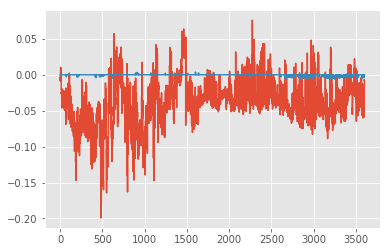

In [10]:
plt.plot(h)
plt.plot(tec[0,0,41,:])
plt.show()

In [11]:
phase_pred = tec[:,:,:,None,:]*-8.448e9/freqs[:, None]

In [12]:
def wrap(phi):
    return np.angle(np.exp(1j*phi))

In [13]:
dphase = (phase - phase_pred)/np.pi/2.
weights = np.where(np.abs(dphase) > 0.5, 0., 1.).mean(-2)


In [14]:
_p = phase_pred - 2*np.pi*np.arange(-2,3,1)[where]

NameError: name 'where' is not defined

In [ ]:
plt.plot(weights[0,0,51,:])
plt.show()

In [ ]:
plt.plot(wrap(phase[0,0,51,:48,:200].T))
# plt.plot(phase_pred[0,0,51,1,:])
plt.show()

In [ ]:
def plot_kern_sol(kern):
    def func(x, w, mu, v):
        r = np.sum(w[:, None]*np.cos(2*np.pi*x[None,:]*mu[:,None])*np.exp(-2*np.pi**2*x[None,:]**2*v[:,None]),axis=0)
        return r
    time_lag = np.linspace(0, 500, 100)
    dir_lag = np.linspace(0., 3, 100)
    
    Kt = func(time_lag, kern.w, kern.mu, kern.v)
    plt.plot(time_lag, Kt)
    plt.show()
    
#     Kt = func(dir_lag, kern.w[:,0], kern.mu[:,0], kern.v[:,0])
#     plt.plot(dir_lag, Kt)
#     plt.show()
    
#     Kt = func(dir_lag, kern.w[:,1], kern.mu[:,1], kern.v[:,1])
#     plt.plot(dir_lag, Kt)
#     plt.show()

In [17]:
kerns = calculate_empirical_spectral_kern(tec[..., :200],time.mjd[:200]*86400., np.array([directions.ra.deg, directions.dec.deg]).T)

In [ ]:
def get_empirical_time_kernel(y, Fs, block_size=None):
    """
    Calcualgte the empirical kernel in time for blocks.
    Args:
        y : array [Nd, Na, Nt]
    Returns:
        lag (Nlag,), K (Na, Nlag, Nblocks) if block_size is not None else (Na, Nlag)

    """
    #Nd, Na, Nt
    y = y - y.mean(-1,keepdims=True)
    k = np.zeros([Na,Nt])
    ks = np.zeros([Na,Nt])
    #Na, Nt, Nt
    C = np.mean(y[:,:, :, None]*y[:,:,None,:], axis=0)
    for j in range(Na):
        for i in range(y.shape[2]):
            k[j,i] = np.mean(np.diag(C[j,:,:],i))
            ks[j,i] = np.std(np.diag(C[j,:,:],i))
        where = ks[j,:] == 0.
        ks[j,where] = np.mean(ks[j,~where])

    ks /= k[:,0:1]
    k /= k[:,0:1]
    return time.mjd[:200]*86400 - time.mjd[0]*86400. , k , ks


lag, Kt, Kt_s = get_empirical_time_kernel(tec[0,:,:,:200],1./8.)

In [ ]:
plot_kern_sol(kerns[51])
plt.plot(lag,Kt[51,:])
plt.show()

In [10]:
import tensorflow as tf


def solve_spectral_mixture(lag, K, Fs, mu_prior=0.2, kern_sigma = 0.01, N=10000, Q=3):
    
    
    def get_starting_point(lag,K,N=N):
        "Iteratively, solve for each Q with random search"
    
        def _iter(w, mu, v, N):
            #Q,N
            if w is None:
                w = np.ones((1, N))
            else:
                w = np.concatenate( [np.tile(w[:, None], (1, N)), 
                                     np.random.uniform(0., 1., size=[1, N])], axis=0)
                w /= np.sum(w,axis=0,keepdims=True)
            if mu is None:
                mu = np.random.uniform(0., 0.05*0.5*Fs, size=[1, N])
            else:
                mu = np.concatenate([np.tile(mu[:, None], (1, N)), 
                                     np.random.uniform(0., mu_prior*0.5*Fs, size=[1, N])], axis=0)
            if v is None:
                v = 1/(2*np.pi*np.random.uniform(np.percentile(lag,1), np.max(lag), size=[1, N]))**2
            else:
                v = np.concatenate([np.tile(v[:, None], (1, N)), 
                                    1/(2*np.pi*np.random.uniform(np.percentile(lag,1), np.max(lag), size=[1, N]))**2],axis=0)
            
            #N, T
            r = np.sum(w[:,:, None]*np.cos(2*np.pi*lag[None,None,:]*mu[:,:, None])*np.exp(-np.sqrt(4*np.pi**2*lag[None,None,:]**2*v[:,:,None])),axis=0)
            r = np.mean(np.abs(r - K[None,:])/kern_sigma,axis=1)# N
            a = np.argmin(r)
            return r[a], w[:, a], mu[:,a], v[:, a]
        w,mu,v = None, None, None
        for q in range(Q):
            loss, w, mu, v = _iter(w, mu, v, N)
            
        return w, mu, v
    
    # TF solve this point
    def forward_logistic(x, a, b):
        ex = tf.exp(-x)
        return a + (b - a) / (1. + ex)

    def backward_logistic(y, a, b):
        return -np.log((b - a) / (y - a) - 1.)

    def optimize_kern(w_init, mu_init, v_init, epochs = 1000):
        
        if w_init is not None:
            w_init = np.log(w_init)
        if mu_init is not None:
            mu_init = backward_logistic(mu_init, -1e-6, Fs/2.)
        if v_init is not None:
            v_init = np.log(v_init)
        

        def tf_func(x, w, mu,v):
            mu = forward_logistic(mu, 0., Fs/2.)
            r = tf.reduce_sum(tf.exp(w)[:, None] * tf.cos(2*np.pi*x[None, :] * mu[:, None]) *\
                             tf.exp(-tf.sqrt(4*np.pi**2 * x**2 * tf.exp(v[:, None]))), axis= 0)
            return r 

        with tf.Session(graph=tf.Graph()) as sess:

            x_pl = tf.placeholder(tf.float64)
            y_pl = tf.placeholder(tf.float64)
            kern_var_pl = tf.placeholder(tf.float64)
            w = tf.Variable(w_init, name='w',dtype=tf.float64)                
            mu = tf.Variable(mu_init, name='mu',dtype=tf.float64)
            v = tf.Variable(v_init, name='v',dtype=tf.float64)
            
            r = tf_func(x_pl, w, mu, v)

            dy = y_pl - r
            dy = tf.square(dy)/(kern_var_pl)
            loss = 0.5*tf.reduce_mean(dy)# + 0.1*tf.reduce_mean(tf.abs(tf.exp(w[:, None]) / tf.reduce_sum(tf.exp(w))))

            opt = tf.train.AdamOptimizer(1e-3).minimize(loss)

            sess.run(tf.global_variables_initializer())

            for i in range(epochs):
                _, w_, mu_, v_, loss_ = sess.run([opt, w, mu, v, loss], 
                                                 feed_dict = {x_pl:lag, y_pl:K, 
                                                              kern_var_pl:kern_sigma**2})
            print("{} loss {} w {} mu {} v {}".format(i, loss_, 
                                                      np.exp(w_), -1e-6 + (Fs/2. + 1e-6) / ( 1 + np.exp(-mu_)), np.exp(v_)))

        return np.exp(w_), -1e-6 + (Fs/2. + 1e-6) / ( 1 + np.exp(-mu_)), np.exp(v_)
    
    w,mu,v = get_starting_point(lag,K,N=10000)
    w, mu, v = optimize_kern(w, mu, v, 100)
    return w, mu, v

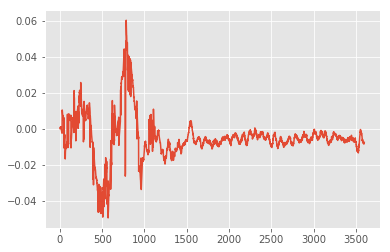

In [3]:
# fill in zeros
tec_r = tec.reshape((-1,Nt))
t = time.mjd*86400. - time[0].mjd*86400.
tec_in = []
for i in range(tec_r.shape[0]):
    mask = tec_r[i,:] == 0.
    if not np.any(mask):
        tec_in.append(tec_r[i,:])
        continue
    nmask = np.bitwise_not(mask)
    if not np.any(nmask):
        tec_in.append(tec_r[i,:])
        continue
    tec_in.append(np.interp(t, t[nmask], tec_r[i,nmask]))

tec = np.stack(tec_in,axis=0).reshape((Npol,Nd,Na,Nt))
phase_pred = tec[...,None,:]*-8.448e9/freqs[:,None]
dphase = phase - phase_pred
jumps = np.median(dphase,axis=-2)
tec += jumps*freqs[-1]/-8.448e9


plt.plot(tec[0,0,50,:])
# plt.ylim(-0.05, 0.05)
plt.show()

In [4]:
y = tec[0,:,51,:500]
y = y - y.mean(-1,keepdims=True)
x = np.arange(500)*8
k = np.zeros(500)
ks = np.zeros(500)
m = np.zeros(500)
C = np.mean(y[:,:, None]*y[:,None,:], axis=0)

for i in range(500):
    k[i] = np.mean(np.diag(C,i))
    ks[i] = np.std(np.diag(C,i))
    
ks /= k[0]
k /= k[0]

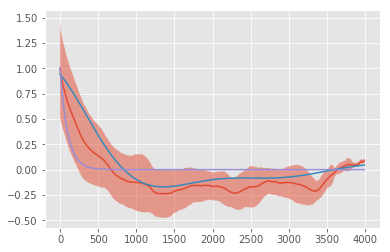

In [5]:
p = solve_spectral_mixture(x[:-1], k[:-1], 1/8., mu_prior=1.0, kern_sigma = ks[:-1], N=30000, Q=3)

def func(x, w, mu, v):
    r = np.sum(w[:, None]*np.cos(2*np.pi*x[None,:]*mu[:,None])*np.exp(-np.sqrt(4*np.pi**2*x[None,:]**2*v[:,None])),axis=0)
    return r

plt.plot(x,k)
plt.fill_between(x,k-ks,k+ks,alpha=0.5)
plt.plot(x,func(x, *p))
plt.plot(x,np.exp(-x/100.))
plt.show()

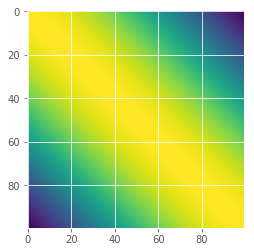

In [6]:
kern =  SpectralMixture(1,p[0],p[2][:,None],p[1][:,None])
plt.imshow(kern.compute_K_symm(np.linspace(0,1000,100)[:,None]))
plt.show()

In [18]:
X = time.mjd[:, None]*86400. - time[0].mjd*86400.
X = np.tile(X[None,:,:],(45,1,1)).reshape((-1, 50))
Y = phase[0,:,51,10,:50].reshape((-1,50))
Y_var = calculate_weights(phase[0,:,51,:,:],indep_axis=-1,N=40)[:,10:11,:50].reshape((-1,50))
Y_freqs = np.tile(freqs[None, 10:11, None], (45, 1, 50)).reshape((-1, 50))

from bayes_tec.likelihoods import WrappedPhaseGaussianEncodedHetero


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/utils/data_utils.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)


In [20]:

with gp.defer_build():
    likelihood = WrappedPhaseGaussianEncodedHetero(tec_scale=0.001)
    kern =  SpectralMixture(1,p[0],p[2][:,None],p[1][:,None])
    model = HeteroscedasticPhaseOnlySVGP(Y_var, Y_freqs, X, Y, 
                                         kern, likelihood, Z = X, minibatch_size=128)
    model.compile()
    
gp.train.ScipyOptimizer().minimize(model,maxiter=100)


2018-10-29 21:30:32,158 Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 216232.490419
  Number of iterations: 4
  Number of functions evaluations: 9


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py:414: RuntimeWarning: divide by zero encountered in true_divide
  self.rho = 1 / np.einsum('ij,ij->i', sk, yk)


In [14]:
gp.train.ScipyOptimizer().minimize(model,maxiter=100)

InvalidArgumentError: Input to reshape is a tensor with 108000 values, but the requested shape has 180000
	 [[Node: HeteroscedasticPhaseOnlySVGP-3a8df48e-54/Reshape_3 = Reshape[T=DT_DOUBLE, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](HeteroscedasticPhaseOnlySVGP-3a8df48e-54/strided_slice_10, HeteroscedasticPhaseOnlySVGP-3a8df48e-54/Reshape_3/shape)]]

Caused by op 'HeteroscedasticPhaseOnlySVGP-3a8df48e-54/Reshape_3', defined at:
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-6626bb848f2c>", line 7, in <module>
    model.compile()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/core/node.py", line 58, in compile
    self.build()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/core/node.py", line 156, in build
    self._build()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/models/model.py", line 79, in _build
    likelihood = self._build_likelihood()
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/decors.py", line 67, in tensor_mode_wrapper
    result = method(obj, *args, **kwargs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/models/heteroscedastic_phaseonly_svgp.py", line 45, in _build_likelihood
    var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y, self.Y_var, self.freqs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/bayes_tec-0.0.1-py3.6.egg/bayes_tec/likelihoods.py", line 445, in variational_expectations
    return ndiag_mc(self.logp, self.num_mc_samples , Fmu, Fvar, Y=Y, Y_var=Y_var, freq=freq)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/gpflow-1.2.0-py3.6.egg/gpflow/quadrature.py", line 230, in ndiag_mc
    Ys[name] = tf.reshape(mc_Yr, (S * N, D_out))  # S * N x D_out
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6199, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 108000 values, but the requested shape has 180000
	 [[Node: HeteroscedasticPhaseOnlySVGP-3a8df48e-54/Reshape_3 = Reshape[T=DT_DOUBLE, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](HeteroscedasticPhaseOnlySVGP-3a8df48e-54/strided_slice_10, HeteroscedasticPhaseOnlySVGP-3a8df48e-54/Reshape_3/shape)]]


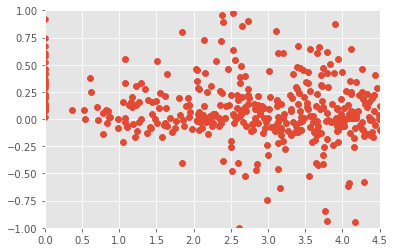

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
y = tec[0,:,40,:100].T
y = y - y.mean(-1,keepdims=True)
x = directions.dec.deg[:]
k = np.zeros(100)
ks = np.zeros(100)
C = np.mean(y[:,:, None]*y[:,None,:], axis=0)
C /= np.mean(np.diag(C))
X = np.sqrt((directions.ra.deg[:, None] - directions.ra.deg[None, :])**2 + (directions.dec.deg[:, None] - directions.dec.deg[None, :])**2)

plt.scatter(X.flatten(), C.flatten())
plt.ylim(-1,1)
plt.xlim(0.,4.5)
plt.show()


for i in range(100):
    k[i] = np.mean(np.diag(C,i))
    ks[i] = np.std(np.diag(C,i))
    
ks /= k[0]
k /= k[0]

## Investigate the empirical kernel in time using STFT

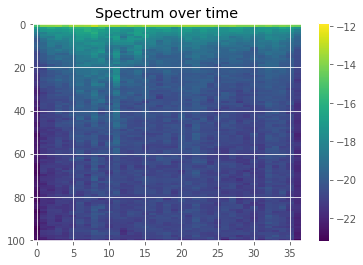

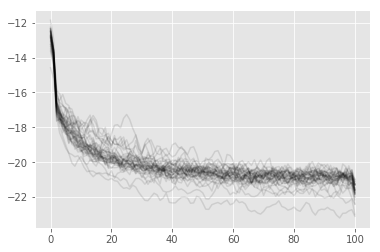

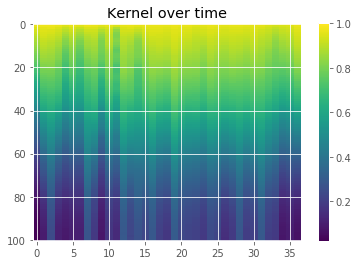

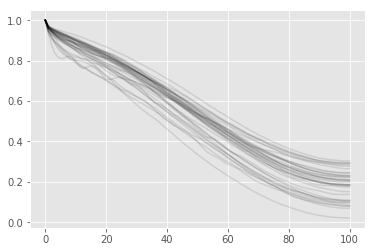

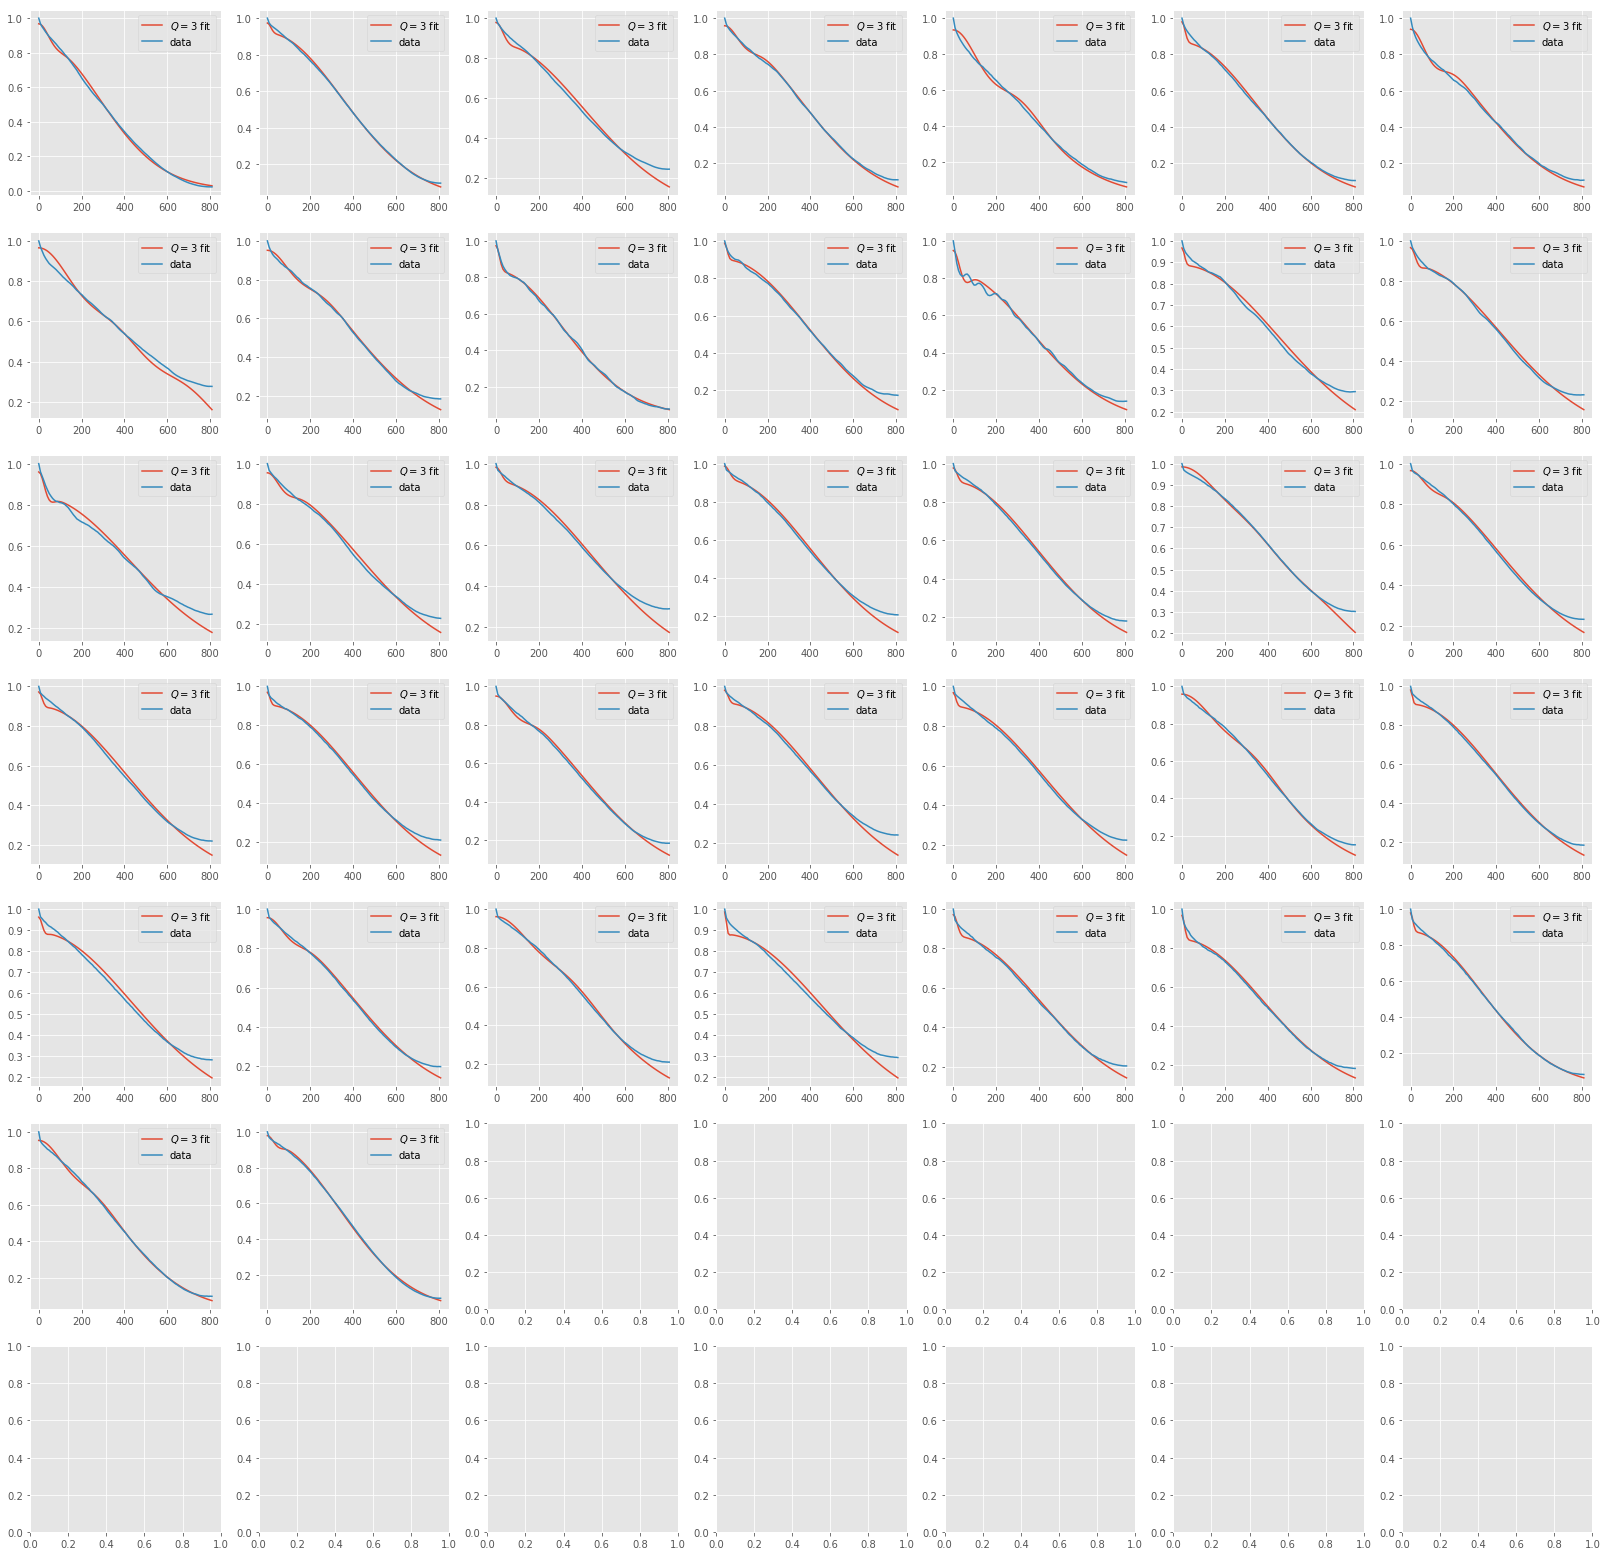

In [146]:
from scipy.signal import stft
from bayes_tec.utils.data_utils import solve_spectral_mixture

Q = 3
kern_sigma = 0.01
Fs = 1/8.
y = tec[0, :, :, :]#tec[0,31:32,:,:] - tec[0,...].mean(axis=-1, keepdims=True)

f,t,sp = stft(y, 1./8., nperseg = 200,detrend = lambda x: (x - 0*x.mean(axis=-1,keepdims=True)), 
              noverlap=None,boundary='constant',axis=-1)
#s . w -> Fs * Fw
#|Fs|^2 = |Ff * Fw^-1 |^2

S = np.exp(np.log(np.maximum(np.abs(sp), 1e-20)**2).mean(0))
K = np.fft.hfft(S,axis=-2)[:,:S.shape[1], :]
K /= K[:,0:1,:]
plt.imshow(np.log(S[21,:,:]),aspect='auto')
plt.colorbar()
plt.title("Spectrum over time")
plt.show()
plt.plot(np.log(S[21,:,:]),c='black',alpha=0.1)
plt.show()

plt.imshow(K[21,:,:],aspect='auto')
plt.title("Kernel over time")
plt.colorbar()
plt.show()
plt.plot(K[21,:,:],c='black',alpha=0.1)
plt.show()

def func(x, w, mu, v):
    r = np.sum(w[:, None]*np.cos(2*np.pi*x[None,:]*mu[:,None])*np.exp(-2*np.pi**2*x[None,:]**2*v[:,None]),axis=0)
    return r


M = int(np.ceil(np.sqrt(K.shape[-1])))
fig, axs = plt.subplots(M,M,figsize=(M*4,M*4))
x = np.linspace(0,K.shape[1]*8, K.shape[1])
lb = np.zeros(Q*3)
ub = np.concatenate([np.ones(Q)*2, np.ones(Q)*Fs/2., np.inf*np.ones(Q)])

for i in range(K.shape[2]):
    ydata = K[21,:,i]
    p = solve_spectral_mixture(x, ydata, 1/8., mu_prior=1., kern_sigma = 0.01, N=30000, Q=3)
    col = int(i%M)
    row = int((i - col)/M)
    ax = axs[row][col]
    ax.plot(x,func(x, *p), label=r'$Q={}$ fit'.format(Q))
    ax.plot(x,ydata,label='data')
    ax.legend()
plt.show()
    

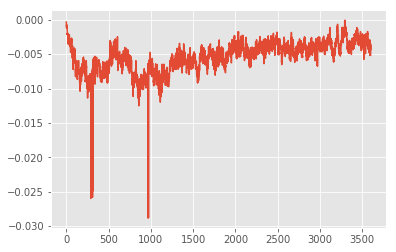

In [149]:
plt.plot(tec[0,0,21,:])
plt.show()


In [161]:
error = np.mean(np.square(phase_pred - phase), axis=-2)

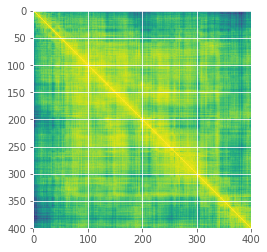

In [209]:
Y = tec[0,:,20,:400]

cov = np.mean(Y[:,:,None]*Y[:,None,:],0)
std = np.sqrt(np.diag(cov))
cor = cov / (std[:,None] * std[None , :])

plt.imshow(cor)
plt.show()

In [205]:
gains = np.exp(1j*phase)*np.arange(3600)

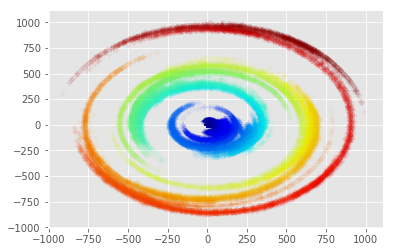

In [206]:
[plt.scatter(gains[0,0,50,l,:1000].real,gains[0,0,50,l,:1000].imag,c=plt.cm.jet(np.arange(1000)/1000), alpha=0.05,marker='+') for l in range(48)]
plt.show()

In [232]:
import gpflow as gp
import tensorflow as tf

X = time.mjd[:,None]*86400. - time[0].mjd*86400.
kern = SpectralMixture(1,kerns[50].w[:,2],kerns[50].mu[:,2:3],kerns[50].v[:,2:3])
K = kern.K(X[:400,:])
q_mu = tf.zeros([400,1],dtype=tf.float64)
q_sqrt = tf.cholesky(K + 1e-3*tf.eye(tf.shape(K)[0], dtype=tf.float64))
K_pl = tf.placeholder(tf.float64)
KL = gp.kullback_leiblers.gauss_kl(q_mu, q_sqrt, K_pl)

sess = kern.enquire_session()
KL_ = sess.run(KL,feed_dict={K_pl: cor + 1e-6*np.eye(400)})

In [233]:
KL_

inf

In [231]:
np.linalg.cholesky(cor + 1e-6*np.eye(400))

array([[1.00000050e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.58568444e-01, 5.12699939e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.99677203e-01, 4.91493751e-01, 3.44893118e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.47890539e-01, 4.26116509e-01, 9.22529775e-02, ...,
        1.13401693e-03, 0.00000000e+00, 0.00000000e+00],
       [3.57441836e-01, 3.73592134e-01, 1.32721087e-01, ...,
        1.94668642e-04, 1.13318830e-03, 0.00000000e+00],
       [3.93081580e-01, 4.32330732e-01, 1.76836853e-01, ...,
        1.57393820e-04, 1.46060011e-04, 1.11549505e-03]])

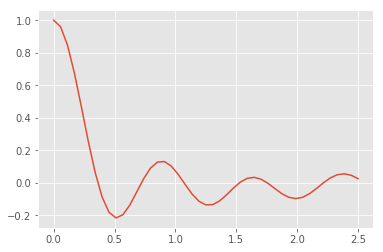

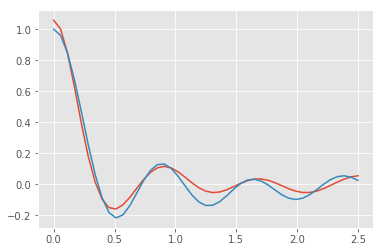

In [72]:
# compute Fourier over directions sum_k e^{-2 pi i k t + pt'} x_k = W_tt'kp x_kp
Fs = np.sqrt(45)/2.5

fourier_freqs = np.linspace(-Fs/2., Fs/2., 45)
ra = directions.ra.deg
dec = directions.dec.deg

W = np.exp(-2j*np.pi*(fourier_freqs[:, None]*dec[None,:]))
x = tec[0,:, 3, 1000:1600]

xf = np.log(np.maximum(np.abs(np.einsum('ab,bc->ac',W,x)), 1e-20)).mean(1)

dir_freqs = np.linspace(0, 2.5, 45)

Wf = np.exp(2j*np.pi*(dir_freqs[:, None]*fourier_freqs[None,:]))

K = np.einsum("ab,b->a",Wf, np.exp(xf)).real
K /= K[0]
# f,t,sp = stft(y, 1./8., nperseg = 200,detrend = lambda x: (x - 0*x.mean(axis=-1,keepdims=True)), 
#               noverlap=None,boundary='constant',axis=-1)
# S = np.exp(np.log(np.maximum(np.abs(sp), 1e-20)**2).mean(0))
# K = np.fft.hfft(S,axis=-2)[:,:S.shape[1], :]
# K /= K[:,0:1,:]

plt.plot(dir_freqs, K)
plt.show()

def func(x, w, mu, v):
    r = np.sum(w[:, None]*np.cos(2*np.pi*x[None,:]*mu[:,None])*np.exp(-2*np.pi**2*x[None,:]**2*v[:,None]),axis=0)
    return r

w, mu, v = solve_spectral_mixture(dir_freqs,K,Fs, mu_prior=1., N=20000)
plt.plot(dir_freqs,func(dir_freqs, w, mu, v), label=r'$Q={}$ fit'.format(Q))
plt.plot(dir_freqs,K,label='data')

plt.show()

## Get the difference of kernels from average

In [1128]:
Q = 3
kern_sigma = 0.01
Fs = 1/8.

def get_empirical_time_kernel(y, Fs, block_size=200):
    """
    Calcualgte the empirical kernel in time for blocks.
    Args:
        y : array [Nd, Na, Nt]
    Returns:
        lag (Nlag,), K (Na, Nlag, Nblocks)
    """
    y = y# - y.mean(axis=-1, keepdims=True)
    f,t,sp = stft(y, Fs, nperseg = block_size, 
              noverlap=0,boundary='constant',axis=-1)
    
    S = np.exp(np.log(np.maximum(np.abs(sp), 1e-20)**2).mean(0))
    K = np.fft.hfft(S,axis=-2)[:,:S.shape[1], :]
    K /= K[:,0:1,:]#Na, Nlag, Nblocks
    lag = np.linspace(0.,K.shape[1]/Fs, K.shape[1])
    return lag, K


Ks = []
for k in range(Nd):
    y = tec[0,k:k+1, :, :2000]
    lag, K = get_empirical_time_kernel(y, Fs, block_size=2000)
    Ks.append(K)

y = tec[0,:, :, :2000]
lag, K_mean = get_empirical_time_kernel(y, Fs, block_size=2000)


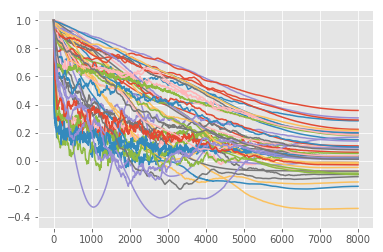

In [1129]:
plt.plot(lag, K_mean[40,:, 0])
[plt.plot(lag,Ks[i][40,:,0]) for i in range(Nd)]
plt.show()

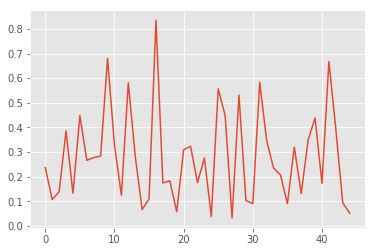

[16  9 41 31 12 25 28  5 26 39 42  3 38 32 10 21 36 20 13  8  7 23  6  0
 33 34 18 22 17 40  2  4 37 11 15  1 29 43 30 35 14 19 44 24 27]


In [1130]:
res = [np.max(Ks[i][51,:,0] - K_mean[51,:,0]) for i in range(Nd)]
plt.plot(res)
plt.show()
print(np.argsort(res)[::-1])

2018-10-17 17:19:46,469 Beginnig search
2018-10-17 17:19:46,726 Shape of x must be 2D at computation.
2018-10-17 17:19:47,673  constraints: array([], dtype=float64)
         fun: array([62.78085819])
     message: 'OK'
        nfev: 0
     success: True
           x: array([[-0.38535849, -0.46846911, -6.13658635,  1.62066427, -5.61390088,
        -3.50954809, -0.82119304, -3.43869907, -0.87254381, -0.56526831,
        -0.97026462,  1.09563321, -1.35004388,  1.46178995, -1.47549447]])


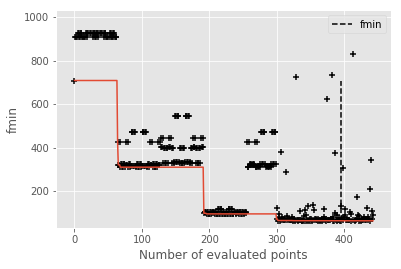

2018-10-17 17:19:47,967 0 (396)  : 62.7808581890238 -> {'w0': 0.6802067454813486, 'w1': 0.6259598100356496, 'w2': 0.0021622923360180204, 'v0': 5.056448040072732, 'v1': 0.0036468157878139233, 'v2': 0.029910428211022248, 'v3': 0.43990651604568454, 'v4': 0.032106426410227804, 'v5': 0.4178871719959606, 'mu0': 0.5682076705864691, 'mu1': 0.37898273782349495, 'mu2': 2.9910760572221364, 'mu3': 0.25922888473211375, 'mu4': 4.313673883053345, 'mu5': 0.22866562995162104}
2018-10-17 17:19:47,969 1 (383)  : 62.89674132191027 -> {'w0': 0.3485213098365787, 'w1': 0.0018227755893677536, 'w2': 0.010575344038159636, 'v0': 0.6631371434242658, 'v1': 8.80137611590959, 'v2': 0.6096549741350167, 'v3': 0.03347742598462262, 'v4': 0.1182070005573898, 'v5': 0.19996063885610824, 'mu0': 0.532864782128638, 'mu1': 0.12289527348939104, 'mu2': 1.3103349593972007, 'mu3': 0.39032704420835823, 'mu4': 0.5400014964914854, 'mu5': 2.4035409739881963}
2018-10-17 17:19:47,971 2 (416)  : 63.067659445151655 -> {'w0': 2.40132956953

In [5]:
bo = BayesHPOpt(run,kw_params=False,init='dir_kern_sm_params_second.hdf5',t=0.5)
bo.add_continuous_param('w0',0.001,10.,log=True)
bo.add_continuous_param('w1',0.001,10.,log=True)
bo.add_continuous_param('w2',0.001,10.,log=True)
bo.add_continuous_param('v0',0.001,10.,log=True)
bo.add_continuous_param('v1',0.001,10.,log=True)
bo.add_continuous_param('v2',0.001,10.,log=True)
bo.add_continuous_param('v3',0.001,10.,log=True)
bo.add_continuous_param('v4',0.001,10.,log=True)
bo.add_continuous_param('v5',0.001,10.,log=True)
bo.add_continuous_param('mu0',0.1,10.,log=True)
bo.add_continuous_param('mu1',0.1,10.,log=True)
bo.add_continuous_param('mu2',0.1,10.,log=True)
bo.add_continuous_param('mu3',0.1,10.,log=True)
bo.add_continuous_param('mu4',0.1,10.,log=True)
bo.add_continuous_param('mu5',0.1,10.,log=True)
res = bo.run('dir_kern_sm_params_second.hdf5',init_design_size=0,n_iter=0,
       plot=True,likelihood_uncert=0.1,design='fac')
# liks = []
# vs = []
# for i in range(50):
#     l, v = run()
#     liks.append(l)
#     vs.append(v)
#     a = np.argsort(v[0])[::-1]
#     print(l)
#     print('w',v[0][a])
#     print('mu',1./v[1][a])
#     print('v',1./np.sqrt(v[2][a]))

In [51]:
mu_d = np.array([[ 1.20855767, -2.2913272 ],
 [-0.02987577,  0.08577883],
 [-1.60478416, -0.73187073]])
v_d = np.array([[0.11952116, 0.44740889],
 [0.02863404, 0.06247903],
 [0.02842412, 0.00732592]])
w_d = np.array([0.16671566 0.94456167 0.01302791])

# v_d[0] = 1./2**2
# mu_d[0] = 1./2

kern = SpectralMixture(2,w=w_d,v=v_d, mu=mu_d)
kern.plot_spectrum(dim=1,yscale='log')

2018-10-17 17:38:48,821 Shape of x must be 2D at computation.
-73.73392179531365
-41.39037868038798


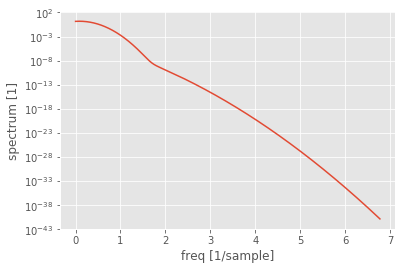

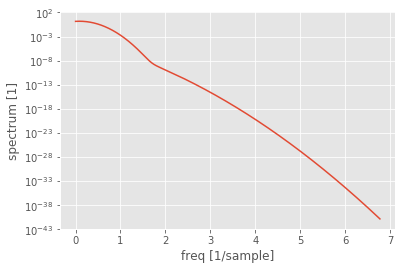

In [53]:
_, (w,mu,v) =run(np.concatenate([w_d, v_d.flatten(), mu_d.flatten()]))
kern = SpectralMixture(2,w=w,v=v, mu=mu)
kern.plot_spectrum(dim=1,yscale='log')

In [60]:
print(w,v,mu)

[0.16671566 0.94456167 0.01302791] [[0.11952116 0.44740889]
 [0.02863404 0.06247903]
 [0.02842412 0.00732592]] [[ 1.20855767 -2.2913272 ]
 [-0.02987577  0.08577883]
 [-1.60478416 -0.73187073]]


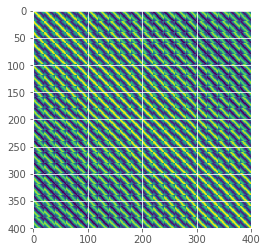

In [54]:
X_d = np.array([directions.ra.deg-directions.ra.deg.mean(),
                    directions.dec.deg-directions.dec.deg.mean()]).T
X_d = np.meshgrid(np.linspace(0.,0.5,20),np.linspace(0.,0.5,20),indexing='ij')
X_d = np.array([X_d[0].flatten(),X_d[1].flatten()]).T
K = kern.compute_K_symm(X_d)

plt.imshow(K)
plt.show()

484.78010111269214
[0.59492659 0.179626   0.02108895]
[[68.03413471]
 [33.69171398]
 [15.67027719]]
[[5519.31906065]
 [ 439.55542583]
 [ 198.24519233]]


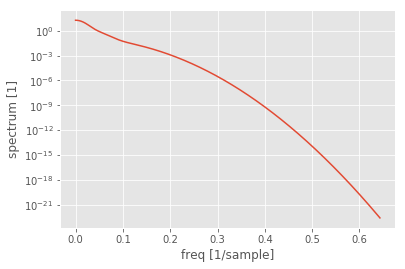

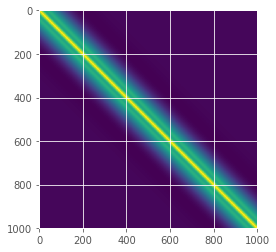

In [71]:
# liks = np.array(liks)
# i = np.argmax(liks)

# print(liks[i])
# w = vs[i][0]
# v=vs[i][2]
# mu=vs[i][1]
# a = np.argsort(w)[::-1]
# print(w[a])
# print(1/np.sqrt(v[a]))
# print(1./mu[a])

w_t = np.array([0.59492659, 0.179626,   0.02108895])
v_t = (1/np.array([[68.03413471],
 [33.69171398],
 [15.67027719]]))**2
mu_t = 1./np.array([[5519.31906065],
 [ 439.55542583],
 [ 198.24519233]])
kern = SpectralMixture(1,w=w_t,v=v_t,mu=mu_t)
kern.plot_spectrum()
K = kern.compute_K_symm(X)
plt.imshow(K)
plt.show()

In [66]:
X = time.mjd*86400.
X -= X[0]
X = X[:, None]
Y = phase[0,0,0,0,:, None]
#     freqs = np.ones_like(Y)*freqs[0]
#     Y_var = np.ones_like(Y)*0.1**2#calculate_weights(phase,indep_axis=-1,N=40)[0,0,0,0,:,None]
with gp.defer_build():
#     kern = SpectralMixture(1, np.random.uniform(size=3), 1/np.random.uniform(8.,50.,size=(3,1))**2, 1./np.random.uniform(16.,100.,size=(3,1)))
#     kern.mu.transform = gp.transforms.Logistic(0., 1./16.)
#     model = gp.models.GPR(X[:500,:],Y[:500,:],kern)
    kern.w.trainable = True
    kern.mu.trainable = True
    kern.v.trainable = True
    model = gp.models.SVGP(X,Y,kern,gp.likelihoods.Gaussian(),Z = X[::10,:])
    model.likelihood.variance = (6.*np.pi/180.)**2
    model.likelihood.trainable = False
    model.compile()

# likelihood = ItohGaussianEncodedHetero(tec_scale=0.005)
# model = HeteroscedasticPhaseOnlySVGP(Y_var, freqs, freqs,freqs, X,Y,kern, likelihood,Z=X)
gp.train.NatGradOptimizer(0.1).minimize(model,var_list=[[model.q_mu,model.q_sqrt]],maxiter=10)
# gp.train.ScipyOptimizer().minimize(model)



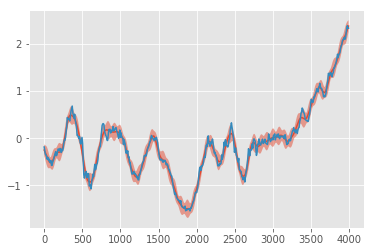

In [67]:
ystar, varstar = model.predict_y(X[:500,:])
plt.plot(X[:500,:],ystar)
plt.fill_between(X[:500,0],ystar[:,0]-np.sqrt(varstar[:,0]),ystar[:,0]+np.sqrt(varstar[:,0]),alpha=0.5)
plt.plot(X[:500,:],Y[:500,:])
plt.show()

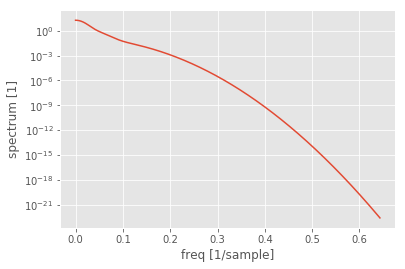

In [68]:
kern.plot_spectrum(yscale='log')

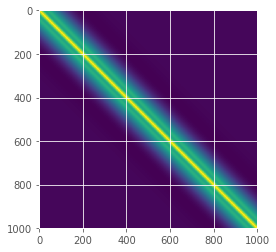

In [51]:
K = kern.compute_K_symm(X)
plt.imshow(K)
plt.show()

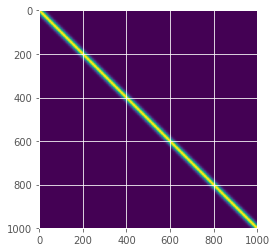

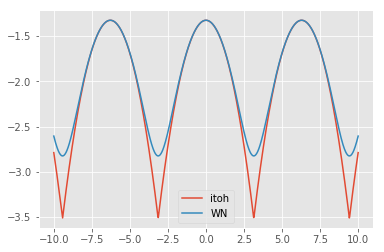

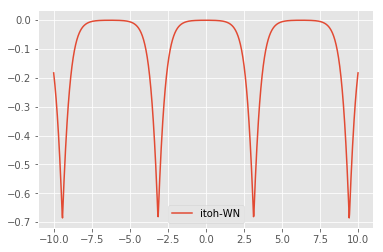

In [69]:
def wrap(phi):
    return np.angle(np.exp(1j*phi))

def logItohN(phi,mu,sd):
    dphi = wrap(wrap(mu) - wrap(phi))
    return -0.5*dphi**2/sd**2 - 0.5*np.log(2*np.pi) - np.log(sd)

def logWN(phi,mu,sd):
    d = [(2*np.pi*sd**2)**-0.5 * np.exp(-0.5*(mu - phi + 2* np.pi*k)**2/sd**2) for k in range(-10,11,1)]
    return np.log(np.sum(np.stack(d,axis=0),axis=0))

phi = np.linspace(-10,10,1000)
mu = 0.
sd = 1.5
c1 = logItohN(phi,mu,sd)
c2 = logWN(phi,mu,sd)

plt.plot(phi,c1,label='itoh')
plt.plot(phi,c2,label='WN')
plt.legend()
plt.show()
plt.plot(phi,c1-c2,label='itoh-WN')
plt.legend()
plt.show()